# This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation (User Specified) Using the past 60 day stock price.

In [3]:

import os
import math
import datetime
from sklearn.preprocessing import MinMaxScaler # Used for scaling data from 0-1 for normalization
from tensorflow.python.keras import Sequential # Turns a model into a Sequential object for training methods
from tensorflow.python.keras.layers import Dense, LSTM # Used for adding layers to the Sequential Object
import pandas_datareader as web # Used for pulling stock data from yahoo finance
# Used for checking user input of stock choice with try-except block to catch invalid inputs
from pandas_datareader._utils import RemoteDataError
import numpy as np # Used for arranging and reshaping data to fit LSTM model
import pandas as pd # Used to create a dataframe of data in order to filter data
import matplotlib.pyplot as plt # Used for visualizations of the data


# Get rid of false-positive warning messages
# The program runs as expected these warnings
# are not crucial to functionality
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None
plt.style.use('fivethirtyeight')

In [4]:
# Creates two date variables for use in the loop below
current_date = datetime.date.today()
past_date = current_date.replace(year=current_date.year - 5)

# Takes in user input for a stock symbol and then pulls the stock data
# from yahoo finance using the symbol provided
# Loops until user inputs a valid stock symbol choice
while True:
    try:
        
        stock = input("""Note: Stock data is pulled from yahoo finance.
Available stock choices can be found on finance.yahoo.com\n
Enter stock symbol for the stock you'd like to see data on: 
(Ex: GOOG for Google, AAPL for Apple): """).upper()
        
        # Reads stock data from yahoo finance using user-inputted stock symbol
        # Uses the current day's date as the end date and then 5 years prior to
        # the current date for the start date in order to pull 5 years of data
        df = web.DataReader(stock, data_source='yahoo', start=past_date, end=current_date)
        break
        
    except RemoteDataError:
        print("Stock choice invalid. Please try again.")

Note: Stock data is pulled from yahoo finance.
Available stock choices can be found on finance.yahoo.com

Enter stock symbol for the stock you'd like to see data on: 
(Ex: GOOG for Google, AAPL for Apple): AAPL


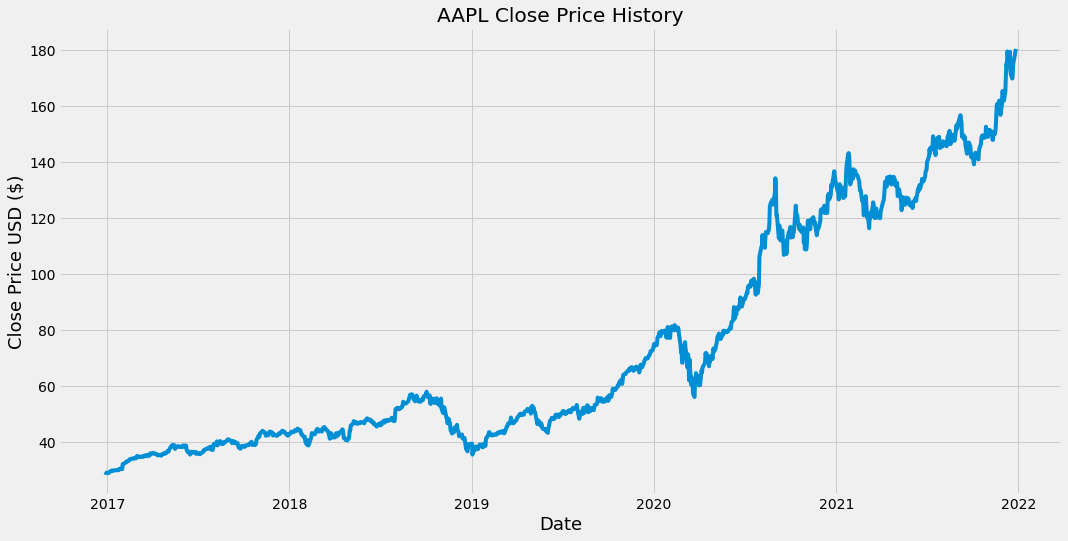

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-12-27,29.450001,29.122499,29.129999,29.315001,73187600.0,27.593676
2016-12-28,29.504999,29.049999,29.379999,29.190001,83623600.0,27.476015
2016-12-29,29.277500,29.100000,29.112499,29.182501,60158000.0,27.468956
2016-12-30,29.299999,28.857500,29.162500,28.955000,122345200.0,27.254816
2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.332472
...,...,...,...,...,...,...
2021-12-20,170.580002,167.460007,168.279999,169.750000,107499100.0,169.750000
2021-12-21,173.199997,169.119995,171.559998,172.990005,91185900.0,172.990005
2021-12-22,175.860001,172.149994,173.039993,175.639999,92135300.0,175.639999


In [5]:
# Visualize the raw closing price history of stock choice in a line graph
plt.figure(figsize=(16, 8))
plt.title(f'{stock} Close Price History')
# Plots only the Close price data
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# Displays dataframe of the raw stock data
df

In [6]:
# Creates a new dataframe that contains only the Close price data
data = df.filter(['Close'])

# Converts the dataframe into a numpy array
dataset = data.values

# Get the number of rows to train the model on
# math.ceil used to round up and not have real number as value
# Takes 85% of data set
training_data_len = math.ceil(len(dataset) * .85)

In [7]:
# Scale, fit, and transform the data to 0-1 inclusive
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0023782 ],
       [0.00155244],
       [0.0015029 ],
       ...,
       [0.96901733],
       [0.97324523],
       [1.        ]])

In [8]:
# Create the scaled training data set
# This grabs the data up to the cutoff in order to only grab data
# we want to train the model with
train_data = scaled_data[0:training_data_len , :]


# Create two empty training data lists
x_train = []
y_train = []


# x_train - contains past 60 values each passthrough
# y_train - contains next value each passthrough
# This allows 60 values to be used to train for a predition on the value after
# Each cycle then uses the previous prediction for the next
for num in range(60, len(train_data)):
    x_train.append(train_data[num-60:num, 0])
    y_train.append(train_data[num, 0])

In [9]:
# Converts both training sets to numpy arrays for reshaping
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
# Re-shape the data
# LSTM needs 3-dimensional data, currently the arrays are 2-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1011, 60, 1)

In [11]:
# This creates a Sequential model and builds the LSTM model from it
# This is done by adding 4 layers, 2 LSTM layers and 2 dense layers for the 2 LSTM layers
# The Dense layers are for connecting the outputs and data together for continuous learning
# The LSTM model is what uses the data itself in order to make the predictions with help of
# the connections through Dense layers.
# The input shape of LSTM is supposed to be (60, 1) similar to the for loop above for
# the training data. x_train.shape[1] is equal to 60 here and provides a better robust
# way of setting the input shape
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
# Compiles the model using adam optimized and mean_squared_error for the loss
# Accuracy is calculated later using mean_squared_error as well
# adam optimizer is widely used for deep learning models such as LSTM
# as it is very efficient
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Trains the model using the training data created
# batch_size is how big the training sets are and epochs is the number
# of iterations of batches. 
# These values could be changed for better or worse accuracy
# This combination resulted in relatively good accuracy without
# a huge runtime cost.
model.fit(x_train, y_train, batch_size=64, epochs=40)

Epoch 1/40
16/16 [==============================] - 3s 52ms/step - loss: 0.0217
Epoch 2/40
16/16 [==============================] - 1s 51ms/step - loss: 0.0032
Epoch 3/40
16/16 [==============================] - 1s 51ms/step - loss: 7.4168e-04
Epoch 4/40
16/16 [==============================] - 1s 53ms/step - loss: 5.3735e-04
Epoch 5/40
16/16 [==============================] - 1s 52ms/step - loss: 4.8949e-04
Epoch 6/40
16/16 [==============================] - 1s 52ms/step - loss: 4.5968e-04
Epoch 7/40
16/16 [==============================] - 1s 51ms/step - loss: 4.5951e-04
Epoch 8/40
16/16 [==============================] - 1s 52ms/step - loss: 4.2853e-04
Epoch 9/40
16/16 [==============================] - 1s 48ms/step - loss: 4.2222e-04
Epoch 10/40
16/16 [==============================] - 1s 52ms/step - loss: 4.1430e-04
Epoch 11/40
16/16 [==============================] - 1s 51ms/step - loss: 4.0170e-04
Epoch 12/40
16/16 [==============================] - 1s 47ms/step - loss: 3.9192e-

In [14]:
# Creates another test data set containing 
# the rest of the data not used in the training sets
test_data = scaled_data[training_data_len - 60: , :]
# Creates two new lists with one being empty
# and the other y_test containing the training values
x_test = []
y_test = dataset[training_data_len:, :]

# Appends the data that wasn't trained on to x_test
for num in range(60, len(test_data)):
    x_test.append(test_data[num-60:num, 0])
    


In [15]:
# Convert the x_test data to a numpy array
x_test = np.array(x_test)

In [16]:
# Re-shape this data for LSTM model 2d-3d
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
# Gets the models predicted values for the values
# that were not trained on 
predictions = model.predict(x_test)

# Inverse transforming the data
# This unscales the values back to non 0-1
# in order for us to see the real prices
predictions = scaler.inverse_transform(predictions)

array([[122.35062 ],
       [122.28887 ],
       [122.44797 ],
       [123.0374  ],
       [123.84244 ],
       [124.877335],
       [126.206184],
       [127.85254 ],
       [129.30762 ],
       [130.85783 ],
       [132.01842 ],
       [133.10843 ],
       [133.98799 ],
       [134.7214  ],
       [135.08813 ],
       [135.2441  ],
       [135.07617 ],
       [135.00034 ],
       [135.0128  ],
       [135.03024 ],
       [134.95444 ],
       [134.81993 ],
       [134.43675 ],
       [134.07478 ],
       [133.23378 ],
       [132.24847 ],
       [131.4627  ],
       [130.92065 ],
       [130.20366 ],
       [129.3719  ],
       [128.21855 ],
       [127.25812 ],
       [126.77938 ],
       [126.49567 ],
       [126.208694],
       [125.94344 ],
       [126.01433 ],
       [126.06107 ],
       [126.286255],
       [126.568146],
       [126.853035],
       [126.93949 ],
       [126.8352  ],
       [126.59775 ],
       [126.39553 ],
       [126.06413 ],
       [125.958305],
       [125.9

In [18]:
# Get the root mean squared error (RMSE) - Measure of how accurate the model is
# lower number = better fit
rmse = np.sqrt(np.mean(((y_test - predictions)**2)))
rmse
# Root mean squared percentage error
rmspe = np.sqrt(np.mean(np.square(((y_test - predictions) / y_test)), axis=0))
print(rmse)
print(rmspe[0] * 100)

3.5200490894457563
2.307805845263832


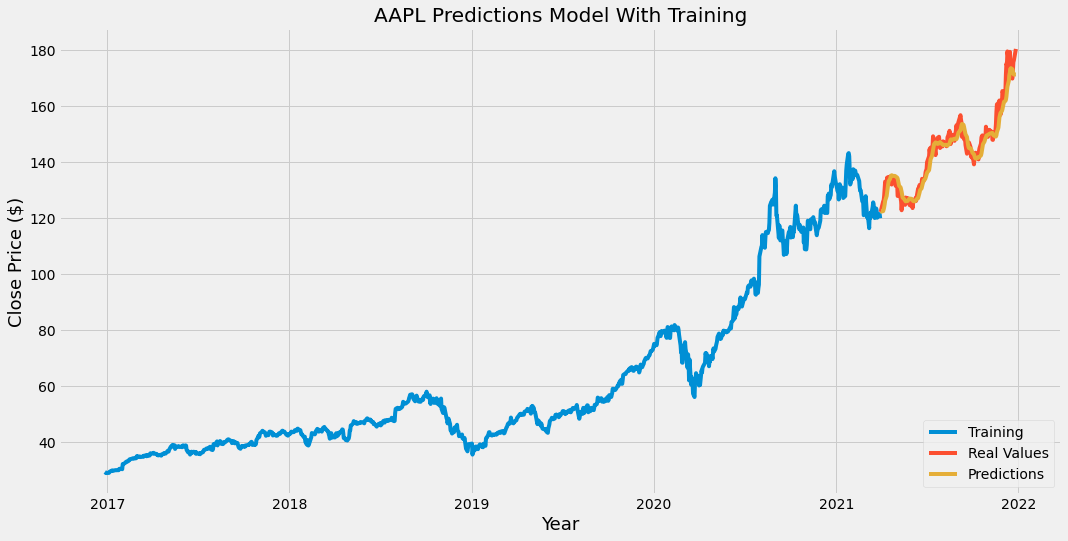

In [29]:
# Sets training_data = closing prices up to the training_data_len
training_data = data[:training_data_len]
# Sets prediction_data to the data after training_data_len
prediction_data = data[training_data_len:]
# Creates another key 'Predictions' and sets it equal to the un-scaled
# prediction values for the close prices in the prediction_data dataset
prediction_data['Predictions'] = predictions

# Visualize the training and predictions in a line graph
# This shows a big look of the overall stock trend and 
# a small look at the predictions compared to the actual
# close prices
plt.figure(figsize=(16,8))
plt.title(f'{stock} Predictions Model With Training')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
# Plots training data close data, and prediction close and predictions data
plt.plot(training_data['Close'])
plt.plot(prediction_data[['Close', 'Predictions']])
plt.legend(['Training', 'Real Values', 'Predictions'], loc='lower right')
plt.savefig(f'models/{stock}_predictions.png')
plt.show()


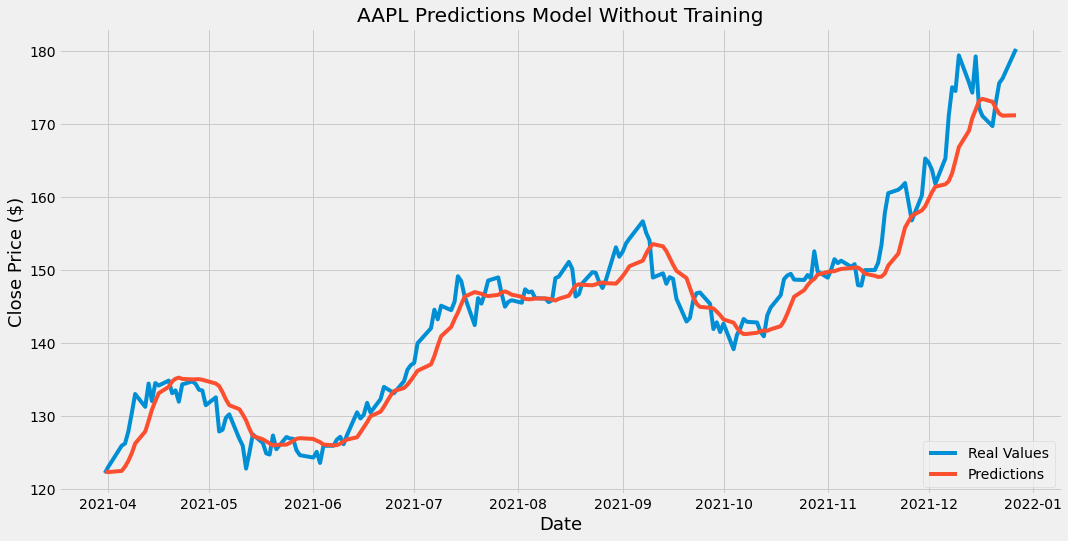

In [28]:

# Plots another line graph displaying a more close up represenation
# of only the Close vs prediction data without training data
# This shows a much closer look at the trends the predictions
# were making and the trend of the price of the stock
plt.figure(figsize=(16,8))
plt.title(f'{stock} Predictions Model Without Training')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($)', fontsize=18)
plt.plot(prediction_data[['Close', 'Predictions']])
plt.legend(['Real Values', 'Predictions'], loc='lower right')

Text(0, 0.5, 'Number of Actual Closes at price')

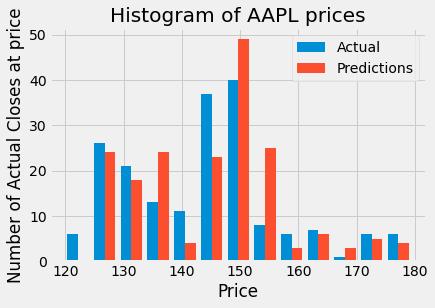

In [193]:
# Creates a Histogram of the close vs prediction prices
# This is useful to see another look at the accuracy of 
# the predictions vs the actual close prices in different
# price categories
plt.hist(prediction_data, bins='auto')
plt.legend(['Actual','Predictions'], loc='upper right')
plt.title(f"Histogram of {stock} prices")
plt.xlabel('Price')
plt.ylabel('Number of Actual Closes at price')

Text(0, 0.5, 'Predictions ($)')

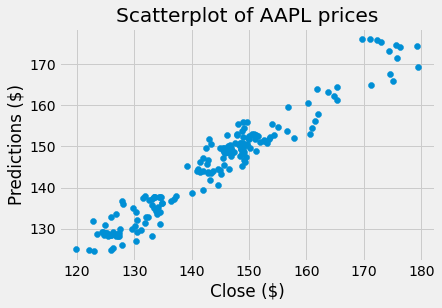

In [203]:

# Creates a scatterplot of the data
# This displays and represents accuracy by
# showing how clustered points are
# if there are more clustered points in the graph
# then there is more accuracy within the predictions
plt.scatter(prediction_data['Close'], prediction_data['Predictions'])
plt.title(f'Scatterplot of {stock} prices')
plt.xlabel('Close ($)')
plt.ylabel('Predictions ($)')

In [59]:
# Saves closing and prediction prices to a csv file
# TODO : CHANGE FOR WINDOWS
prediction_data.to_csv(f"data/{stock}_predictions.csv")
# Displays table data

prediction_data

prediction_csv = pd.read_csv(f"data/{stock}_predictions.csv")

prediction_csv = prediction_csv.sort_values('Date', ascending=False)




In [ ]:
# Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2016-01-01', end='2021-12-20')

# Create a new dataframe
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []

# Append the past 60 days scaled to X_test
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Re-Shape for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)

# Print pred price
print(pred_price)

In [ ]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2021-12-21', end='2021-12-21')
print(apple_quote2['Close'])